# Inference demo for VideoRefer (combined with SAM2)

## Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import math
import os
import argparse
import json
import warnings
from tqdm import tqdm
import transformers
from dataclasses import dataclass, field
from typing import Dict, Optional, Sequence, List
import torch
import sys
sys.path.append('../')
from videollama3 import disable_torch_init, model_init, mm_infer, get_model_output
from videollama3.mm_utils import load_images
from videollama3.mm_utils import load_video
from pycocotools import mask as maskUtils
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

    
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

using device: cuda


## load model

In [2]:
disable_torch_init()

# fill in the model path here
model_path = 'DAMO-NLP-SG/VideoRefer-VideoLLaMA3-7B'
model, processor, tokenizer = model_init(model_path)

/mnt/workspace/workgroup/yuanyq/code/videollama3/ProjectX_region/work_dirs/VideoRefer-VideoLLaMA3-7B


You are using a model of type videollama3_vision_encoder to instantiate a model of type qwen2_vl. This is not supported for all configurations of models and can yield errors.
You are using a model of type videollama3_vision_encoder to instantiate a model of type damovl. This is not supported for all configurations of models and can yield errors.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Some weights of DAMOVLVisionModel were not initialized from the model checkpoint at /mnt/workspace/workgroup/yuanyq/checkpoints/VL3-SigLIP-NaViT and are newly initialized: ['vision_model.embeddings.patch_embedding.bias', 'vision_model.embeddings.patch_embedding.weight', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'visi

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## load video and visualize frame

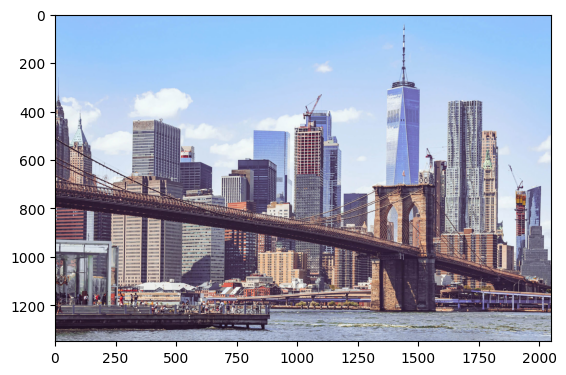

In [4]:
image_path = '../demo/images/1.jpg'
image = Image.open(image_path)
image_data = np.array(image)
plt.imshow(image_data)

## Single-object

#### 1.Selecting Objects with SAM2

In [5]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [7]:
predictor.set_image(image_data)

input_box = np.array([1250, 0, 1600, 700])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

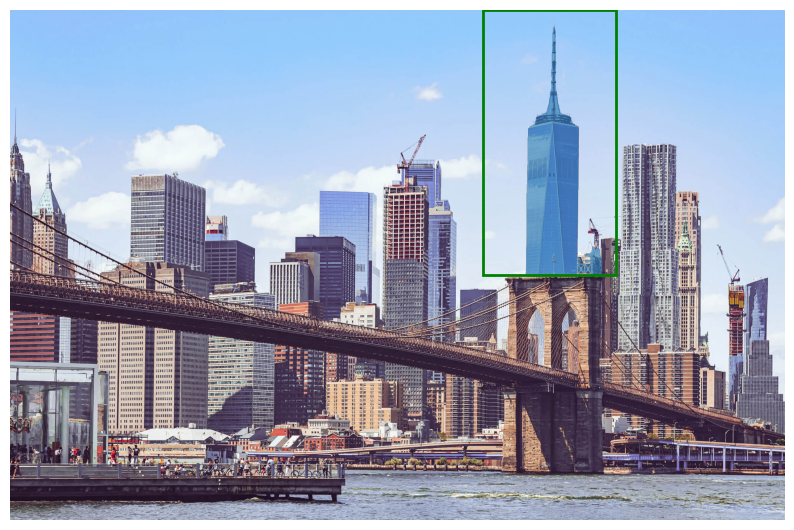

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image_data)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

#### 2. Inference with VideoRefer

In [11]:
question = '<image>\nPlease describe the <region> in the image in detail.'

masks = np.array(masks)
masks = torch.from_numpy(masks).to(torch.uint8)

mask_ids = [0]

output = get_model_output(
    [image_data],
    question,
    model=model,
    tokenizer=tokenizer,
    masks=masks,
    mask_ids=mask_ids,
    modal='image',
    image_downsampling=1,
)
print(output)

/usr/local/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


A tall, modern skyscraper with a sleek, reflective glass facade. The building has a distinctive triangular shape with a pointed top, featuring a series of vertical lines running down its length. Near the top, there is a circular observation deck with a railing, and above it, a spire with multiple horizontal bands.


## Multi-objects

1.Selecting objects with SAM2

In [13]:
predictor.set_image(image_data)

input_box1 = np.array([1250, 0, 1600, 700])
input_box2 = np.array([900, 300, 1100, 800])

masks1, scores1, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box1[None, :],
    multimask_output=False,
)
masks2, scores2, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box2[None, :],
    multimask_output=False,
)

In [16]:
question = '<image>\nThere are two regions in the image: <region0><region>, <region1><region>. Which is taller? <region0> or <region1>?'

masks = []
masks.append(masks1[0])
masks.append(masks2[0])
masks = np.array(masks)
masks = torch.from_numpy(masks).to(torch.uint8)

mask_ids = []
for i in range(len(masks)):
  mask_ids.append(0)

output = get_model_output(
    [image_data],
    question,
    model=model,
    tokenizer=tokenizer,
    masks=masks,
    mask_ids=mask_ids,
    modal='image',
    image_downsampling=1,
)
print(output)

<region0> is taller. <region0> is a skyscraper with a pointed top, while <region1> is under construction and shorter in height.
